In [2]:
import ee
ee.Initialize()

In [3]:
import datetime
import pandas as pd

In [124]:
def get_data(startTime,endTime,lat,lon):   

    try:
        point = {'type':'Point', 'coordinates':[lon,lat]}; 
    
        #Read Landsat 8 Image
        L8_DN = ee.ImageCollection('LANDSAT/LC8_L1T').filterDate(startTime, endTime)
        L8_DN = L8_DN.filterBounds(point)
        L8_DN = L8_DN.sort('CLOUD_COVER').first()

        image = ee.Image(L8_DN)
        tir = image.select(u'B10')
        red = image.select(u'B4')
        nir = image.select(u'B5')
        ndvi = nir.subtract(red).divide(nir.add(red))

        emissivity = ee.Image('NASA/ASTER_GED/AG100_003').select('emissivity_band10').multiply(0.001) 
        srtm = ee.Image('USGS/SRTMGL1_003')
        impervious = ee.Image('USGS/NLCD/NLCD2011').select('impervious')
        
        # computes emissivity-corrected land surface temperature given Landsat8 band 10 (tir) and emissivity
        # assumes tir, emissivity are google earth engine images
        k1 = 774.8853 ; # constants for Landsat8 B10
        k2 =  1321.0789 ; # constants for Landsat8 B10
        dummyk1 = emissivity.multiply(0).add(1).multiply(k1) # make dummy variable same size/type as emissivity
        dummyk2 = emissivity.multiply(0).add(1).multiply(k2) # make dummy variable same size/type as emissivity
    
        # first convert band 10 Digital Number (DN) data to TOA spectral radiance
        radiance = tir.multiply(3.3420E-04).add(.1)  # scale by gain and bias, band specific 
        L_lamda = radiance.divide(emissivity); # correct for emissivity
        k1_over_L_lamda = dummyk1.divide(L_lamda) 
        denominator = k1_over_L_lamda.add(1).log(); 
        t = dummyk2.divide(denominator).subtract(273.15); # finally convert to degrees C 
    
    
        image = ee.ImageCollection(image)
        t = ee.ImageCollection(t)
        ndvi = ee.ImageCollection(ndvi)
        srtm = ee.ImageCollection(srtm)
        impervious = ee.ImageCollection(impervious)
    
        #Get the given Lat,Lon,date
        info = image.getRegion(point,500).getInfo()
        df_image = pd.DataFrame(info[1:],columns=info[0])
    
        #Get the LST (B10)
        info = t.getRegion(point,500).getInfo()
        df_t = pd.DataFrame(info[1:],columns=info[0])
    
        #Get the NDVI
        info = ndvi.getRegion(point,500).getInfo()
        df_ndvi = pd.DataFrame(info[1:],columns=info[0])

        #Get the SRTM
        info = srtm.getRegion(point,500).getInfo()
        df_srtm = pd.DataFrame(info[1:],columns=info[0])

        #Get the impervious
        info = impervious.getRegion(point,500).getInfo()
        df_impervious = pd.DataFrame(info[1:],columns=info[0])

        df = pd.DataFrame()
        df = pd.concat([df,df_image[['longitude','latitude','time']]],axis=1)
        df = pd.concat([df,df_t['emissivity_band10']],axis=1)
        df = pd.concat([df,df_ndvi['B5']],axis=1)
        df = pd.concat([df,df_srtm['elevation']],axis=1)
        df = pd.concat([df,df_impervious['impervious']],axis=1)
        
        df.rename(index=str, columns={"emissivity_band10": "LST"},inplace=True)
        df.rename(index=str, columns={"B5": "NDVI"},inplace=True)
        df['time'] = df['time'].apply(lambda x:datetime.datetime.fromtimestamp(float(str(x)[:-3])))
        df['latitude'] = lat
        df['longitude'] = lon
        return df
    except:
        print("Not Found or Error!")
        return pd.DataFrame

In [126]:
import datetime
from matplotlib import dates
import matplotlib.dates as mdates
from pylab import *

startTime = datetime.datetime(2013, 1, 1)
endTime = datetime.datetime(2016, 1, 1)

collection = ee.ImageCollection('LANDSAT/LC8_L1T').filterDate(startTime, endTime)
point = {'type':'Point', 'coordinates':[ -122.055,37.9917]};  # LA
info = collection.getRegion(point,500).getInfo()

# extract the header column names
header = info[0]
# create a Numpy array of the data
data = array(info[1:])
# extract the time information
iTime = header.index('time')
# convert to Python datetime objects
time_collection = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

In [127]:
#Read list of metereological station
met_loc = pd.read_csv('met_locs_la.csv')
lat = met_loc['latitude'].tolist()
lon = met_loc['longitude'].tolist()
latlon = zip(lat,lon)

In [139]:
import time as time
tic = time.time()

#Create the final Dataframe
df = pd.DataFrame()
counter=0

for time_X in time_collection:
    print(counter)
    loc_counter = 0
    for loc in latlon:
        #print(loc_counter)
        startTime = time_X-datetime.timedelta(days=1)
        endTime = time_X+datetime.timedelta(days=1)
        df_temp = get_data(startTime,endTime,loc[0],loc[1])
        try:
            df = pd.concat([df,df_temp])
        except:
            df = df.copy()
        loc_counter += 1
    counter += 1
    
toc = time.time()
print(toc-tic)

df['time'] = df['time'].apply(lambda x:str(x.date()))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
767.656155109


In [141]:
#Read the Temperature values from the Met stations
Tair_val = pd.read_csv('met_vals_la.csv')
Tair_val.rename(index=str, columns={"day": "time"},inplace=True)

In [142]:
#Do some field cleaning for joining the tables
df['longitude'] = df['longitude'].apply(lambda x:str(x)[0:8])
df['latitude'] = df['latitude'].apply(lambda x:str(x)[0:6])

Tair_val['longitude'] = Tair_val['longitude'].apply(lambda x:str(x)[0:8])
Tair_val['latitude'] = Tair_val['latitude'].apply(lambda x:str(x)[0:6])

In [143]:
#Merge the two Tables
df = pd.merge(df, Tair_val, how='left', on=['latitude', 'longitude', 'time'])
df.drop(['native_id','met_monitor_id'],axis=1,inplace=True)
df = df.dropna(axis=0,how='any') #Drop any rows with missing data

0.458570839336


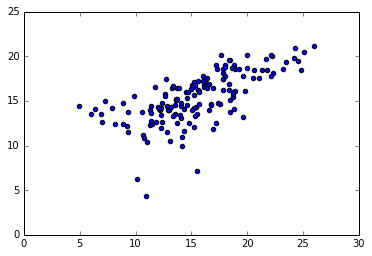

In [159]:
#Do the Regression
X_train = df.drop(['longitude','latitude','time','temp'], axis=1)
y_train = df['temp']
                  

from sklearn.linear_model import LinearRegression
lm = LinearRegression(normalize=True)

lm.fit(X_train,y_train)
predictions = lm.predict(X_train)
plt.scatter(y_train,predictions)

print(lm.score(X_train,y_train))

In [162]:
print(lm.coef_)
print(lm.intercept_)

[  2.23489141e-01  -3.04418862e+01   5.52772717e-03  -1.91607731e-02]
13.8488596335
